In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
#from scipy import special
import scipy.optimize as so
from sympy import *


In [35]:
from functions import *

## CREATION OF OBSERVATION FILES 

i am inventig an array of observations, représenting measurements of temperature in the soil at 5 cm and 10 cm depth. Then i used something to sample it at the wanted frequency, for the data assimilation part i will try to observe which frequency of observation gives enough information to correct the model and give an appropriate solution. 

In [36]:
 #paramètres 
limt=24*10  #10 jours en heures
dt=1/60  #dt 1 minute
tt=np.arange(0,limt,dt)
freq=60  # 4h en minutes 

limx=100
dx=1
xx=np.arange(0,limx,dx)

Nt=len(tt)
Nx=len(xx)

s=5  #standard dev   gaussian
mu=0   #moyenne gaussienne 
K=0.6  #thermal conductivity of soil

In [37]:
#measurements, truth of temperature and time of the measurements 
mes_5cm, true_5cm, tt_obs_5cm= obs_5(dt,limt,freq)

mes_10cm, true_10cm, tt_obs_10cm= obs_10(dt,limt,freq)

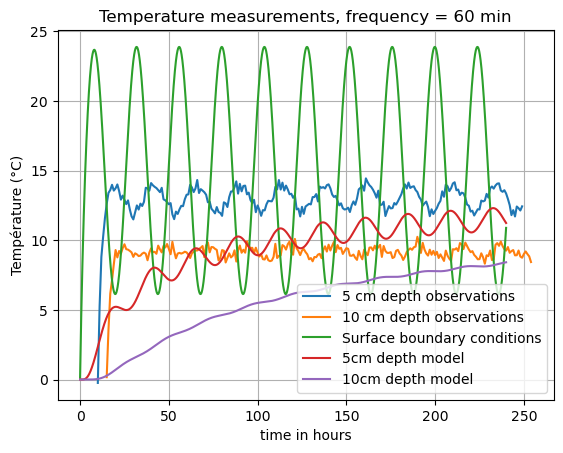

In [39]:
Tf=euler_f_BC_periodic(dx,dt,limx,limt,K)
plt.plot(tt_obs_5cm, mes_5cm,label='5 cm depth observations')
plt.plot(tt_obs_10cm, mes_10cm,label='10 cm depth observations')
plt.plot(tt,Tf[:,0],label='Surface boundary conditions')

plt.plot(tt,Tf[:,5],label='5cm depth model')
plt.plot(tt,Tf[:,10],label='10cm depth model')

plt.title('Temperature measurements, frequency = '+ str(freq)+' min')
plt.xlabel('time in hours')
plt.ylabel('Température (°C)')
plt.legend()
plt.grid()

## DATA ASSIMILATION - 3D VAR


In [27]:
### parameters for 3DVAR

## Type and timing of observations
nvarobs = [5,10]            ## observed variables   mesure à 10,  et 5 cm 
nobs = len(nvarobs)
assim_steps =tt_obs_10cm   # range(0,50,5)  #fréquence d'assimilation 1 fois par heure 
#print(assim_steps)
nassim = len(assim_steps)
#assim_windows = 50   # 50
#_______________________________________________
## Observation operator
hobs = np.zeros((nobs,len(xx)))
j=0
for i in range(nobs):
    hobs[j,nvarobs[i]] = 1 #binaire 1 avec obs 0 aucune obs
    j += 1
print(np.shape(hobs))
#_____________________________________________________________
#observations: mesure de température 
yobs5=mes_5cm
yobs10=mes_10cm
#observation covariance matrix
Robs=0.2**2

#________________________________________
#less and less precise the deeper it is 
#Pmat
Pmat=np.linspace(5,2,len(xx))   #juste les termes diagonaux 
#B = np.eye(3)/(xstd**2)

#____________________________________________________________________________________________



(2, 100)


In [28]:
#euler forward scheme gives prevision of temperature in depth for the next time step using state vector x
def euler_f_assim(x,dt,dx,K,it):
    #it moment ou on commence la simulation numéro de pas de temps        
    Tz=np.zeros(len(x))
    #x #vecteur température en profondeur pour un pas de temps
    x[0]=temp_cycle(tt,dt)[it]
    for j in range(1,len(x)-1):
        Tz[j]=x[j]+(K*dt/(dx**2))*(x[j+1]+x[j-1]-2*x[j])
       
    return Tz #propage pour le pas de temps prochain 



In [ ]:
#DATA ASSIMILATION
#_________________________________

xb_save = np.zeros((Nt,Nx))   # stocke résultats du modèle d'origine 
x_save = np.zeros((Nt,Nx))   #stocke résultats du modèle avec assimilation de données 
x_save[0,:] = gauss(xx, mu, s)
xb_save[:,0]=temp_cycle(tt,dt)# valeur au pas de temps 0   #backgroud
#Var_save = np.zeros((Nt+1,Nx))  #valeur de la variance 
#Var_save[0,:] = Pmat

xb=xb_save[0,:]
for it in range(Nt-1):

#FORECAST
    #champ de température au temps t   background 
    xb=euler_f_assim(xb,dt,dx,K,it)# prévision à t+1 en faisant tourner le modèle 
    
#ANALYSE     
    iobs=0
    if it in tt_obs_10cm:
         
        iit = np.argwhere(tt_obs_10cm==it)[0][0]
        yo = np.array([yobs5[iit], yobs10[iit]])
        res = so.minimize(CostFunction,xb,args=(xb,yo,Pmat,Robs,hobs),  # minimize pour le paramètre xin  avec Cost function 3D VAR
                   method='Powell',
                   options={'maxiter': 30})
        xb=res['x']
        #Pmat= nb
        iobs=+1
        
        
    x_save[it+1,:] = xb
       





In [ ]:
plt.plot(tt,x_save[:,5],label='Analysis')
plt.scatter(tt_obs_5cm,mes_5cm,marker='o',s=5,color='r',label='Observations')
plt.plot(tt,Tf[:,5],label='Model background')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Température (°C)')
plt.grid()

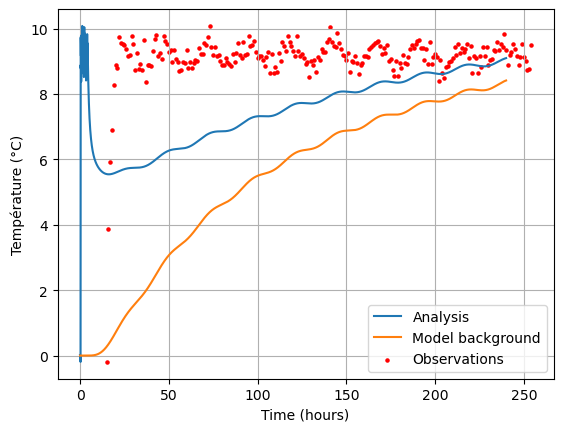

In [31]:
plt.plot(tt,x_save[:,10],label='Analysis')
plt.scatter(tt_obs_10cm,mes_10cm,marker='o',s=5,color='r',label='Observations')
plt.plot(tt,Tf[:,10],label='Model background')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Température (°C)')
plt.grid()